In [1]:
%run 0_3_configure_mlflow.ipynb

Experiment_id: 1
Artifact Location: file:///C:/Users/Piotrek/Documents/Inzynierka/csgo-analysis/mlruns/1
Tags: {}
Lifecycle_stage: active


In [2]:
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import pickle
import shap
import os
import shutil


from sklearn.metrics import accuracy_score, precision_score, recall_score, log_loss, \
        f1_score, RocCurveDisplay, roc_auc_score, make_scorer
from functools import partial
from sklearn.calibration import CalibrationDisplay
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import StratifiedKFold, train_test_split

# Wczytanie danych

In [3]:
def select_feat():
    columns = [
        'seconds', 'ctAlivePlayers', 'ctEqVal', 'tAlivePlayers', 'tEqVal',
       'ct_armor', 't_armor', 'ct_hp', 't_hp', 'ct_hasHelmet', 't_hasHelmet', 'ct_DecoyGrenade',
       't_DecoyGrenade', 'ct_Flashbang', 't_Flashbang', 'ct_HEGrenade',
       't_HEGrenade', 'ct_SmokeGrenade', 't_SmokeGrenade', 'ct_fireGrenades',
       't_fireGrenades', 'ct_isBlinded', 't_isBlinded', 'ct_hasDefuse',
       't_hasBomb', 'ct_isDefusing', 't_isPlanting', 'ct_spottedPlayers',
       't_spottedPlayers', 'ct_grouppedPlayers',
       'ct_meanDist', 'ct_minDist', 't_meanDist','t_minDist',
       't_grouppedPlayers', 'ct_conquerMap', 't_conquerMap', 'ct_activeWeapon_Pistol',
       'ct_activeWeapon_EnhancedPistols', 'ct_activeWeapon_Deagle',
       'ct_activeWeapon_SMG', 'ct_activeWeapon_WeakAssaultRifle',
       'ct_activeWeapon_LunetRifle', 'ct_activeWeapon_SniperRifle',
       'ct_activeWeapon_AssaultRifle', 'ct_activeWeapon_Others',
       't_activeWeapon_Pistol', 't_activeWeapon_EnhancedPistols',
       't_activeWeapon_Deagle', 't_activeWeapon_SMG',
       't_activeWeapon_WeakAssaultRifle', 't_activeWeapon_LunetRifle',
       't_activeWeapon_SniperRifle', 't_activeWeapon_AssaultRifle',
       't_activeWeapon_Others', 'ct_mainWeapon_Pistol',
       'ct_mainWeapon_EnhancedPistols', 'ct_mainWeapon_Deagle',
       'ct_mainWeapon_SMG', 'ct_mainWeapon_WeakAssaultRifle',
       'ct_mainWeapon_LunetRifle', 'ct_mainWeapon_SniperRifle',
       'ct_mainWeapon_AssaultRifle', 't_mainWeapon_Pistol', 't_mainWeapon_EnhancedPistols',
       't_mainWeapon_Deagle', 't_mainWeapon_SMG',
       't_mainWeapon_WeakAssaultRifle', 't_mainWeapon_LunetRifle',
       't_mainWeapon_SniperRifle', 't_mainWeapon_AssaultRifle', 
       'ct_secondaryWeapon_Pistol','ct_secondaryWeapon_EnhancedPistols', 'ct_secondaryWeapon_Deagle',
       't_secondaryWeapon_Pistol', 't_secondaryWeapon_EnhancedPistols',
       't_secondaryWeapon_Deagle', 'ctMinDistToA',
       'ctMinDistToB', 'tMinDistToA', 'tMinDistToB', 'ctMeanDistToA',
       'ctMeanDistToB', 'tMeanDistToA', 'tMeanDistToB', 'ctMeanKills',
       'tMeanKills', 'tScore', 'ctScore', 'de_ancient', 
       'de_dust2', 'de_inferno', 'de_mirage', 'de_nuke', 'de_overpass',
       'de_vertigo','bombsite_A', 'bombsite_B', 'bombsite_not_planted'
    ]
    return columns

In [4]:
df = pd.read_parquet('data/ESTA_states_prepared.parquet', columns=select_feat() + ['matchName', 'demoId', 'roundNum'])
df

,seconds,ctAlivePlayers,ctEqVal,tAlivePlayers,tEqVal,ct_armor,t_armor,ct_hp,t_hp,ct_hasHelmet,...,de_mirage,de_nuke,de_overpass,de_vertigo,bombsite_A,bombsite_B,bombsite_not_planted,matchName,demoId,roundNum
0,0.007874,5,4400,5,4250,400,300,500,500,0,...,0,1,0,0,0,0,1,heroic-vs-big-iem-katowice-2021,00330e8b-ba01-4d3f-a6c1-66881b879dac,1
1,0.511811,5,4400,5,4250,400,300,500,500,0,...,0,1,0,0,0,0,1,heroic-vs-big-iem-katowice-2021,00330e8b-ba01-4d3f-a6c1-66881b879dac,1
2,1.015748,5,4400,5,4250,400,300,500,500,0,...,0,1,0,0,0,0,1,heroic-vs-big-iem-katowice-2021,00330e8b-ba01-4d3f-a6c1-66881b879dac,1
3,1.519685,5,4400,5,4250,400,300,500,500,0,...,0,1,0,0,0,0,1,heroic-vs-big-iem-katowice-2021,00330e8b-ba01-4d3f-a6c1-66881b879dac,1
4,2.023622,5,4400,5,4250,400,300,500,500,0,...,0,1,0,0,0,0,1,heroic-vs-big-iem-katowice-2021,00330e8b-ba01-4d3f-a6c1-66881b879dac,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7464293,81.464567,3,26800,1,24300,290,94,233,74,3,...,0,0,0,1,0,0,1,spirit-vs-copenhagen-flames-pgl-major-antwerp-...,ff910f54-0bed-4fdf-afa8-b481be09a788,26
7464294,81.968504,3,26800,1,24300,290,94,233,74,3,...,0,0,0,1,0,0,1,spirit-vs-copenhagen-flames-pgl-major-antwerp-...,ff910f54-0bed-4fdf-afa8-b481be09a788,26
7464295,82.472441,3,26800,1,24300,286,94,206,74,3,...,0,0,0,1,0,0,1,spirit-vs-copenhagen-flames-pgl-major-antwerp-...,ff910f54-0bed-4fdf-afa8-b481be09a788,26
7464296,82.976378,2,26800,1,24300,194,94,159,74,2,...,0,0,0,1,0,0,1,spirit-vs-copenhagen-flames-pgl-major-antwerp-...,ff910f54-0bed-4fdf-afa8-b481be09a788,26


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7464298 entries, 0 to 7464297
Columns: 102 entries, seconds to roundNum
dtypes: float64(17), int32(6), int64(67), object(2), uint8(10)
memory usage: 5.1+ GB


In [6]:
y = pd.read_parquet("data/ESTA_states_prepared.parquet", columns=["matchName", "winningSideCT"])

## All dataset

In [7]:
filtr = ~df.matchName.str.endswith("iem-katowice-2022")
df = df[filtr].reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7137130 entries, 0 to 7137129
Columns: 102 entries, seconds to roundNum
dtypes: float64(17), int32(6), int64(67), object(2), uint8(10)
memory usage: 4.8+ GB


In [8]:
y = y[filtr].drop(['matchName'], axis='columns')
y = y.reset_index(drop=True)
y

,winningSideCT
0,0
1,0
2,0
3,0
4,0
...,...
7137125,1
7137126,1
7137127,1
7137128,1


In [9]:
groupped = df.groupby(['demoId'])
samples_indexes = groupped.indices
len(samples_indexes)

1494

In [10]:
maps = len(samples_indexes.keys())
np.random.seed(12)
train_ind = np.random.choice(maps, size=int(0.8*maps), replace=False)
train_indexes = np.array([])
valid_indexes = np.array([])
for i, key in enumerate(samples_indexes):
    if i in train_ind:
        train_indexes = np.concatenate((train_indexes, samples_indexes[key]))
    else:
        valid_indexes = np.concatenate((valid_indexes, samples_indexes[key]))

train_indexes.shape, valid_indexes.shape

((5709205,), (1427925,))

In [11]:
X = df.drop(['demoId', 'roundNum', 'matchName'], axis='columns')
y = y.squeeze()
X.shape, y.shape

((7137130, 99), (7137130,))

In [12]:
X_train, y_train = X.iloc[train_indexes], y.iloc[train_indexes]
X_val, y_val = X.iloc[valid_indexes], y.iloc[valid_indexes]
X_train.shape, X_val.shape

((5709205, 99), (1427925, 99))

In [13]:
X_test = pd.read_parquet("data/states_another_mod_test.parquet", columns=select_feat())
y_test = pd.read_parquet("data/states_another_mod_test.parquet", columns=["winningSideCT"])
y_test = y_test.squeeze()
X_test.shape

(620392, 99)

In [14]:
y_train.value_counts(normalize=True), y_val.value_counts(normalize=True), y_test.value_counts(normalize=True)

(1    0.518687
 0    0.481313
 Name: winningSideCT, dtype: float64,
 1    0.522383
 0    0.477617
 Name: winningSideCT, dtype: float64,
 1    0.5046
 0    0.4954
 Name: winningSideCT, dtype: float64)

In [15]:
parameters = {
    "max_leaves": Integer(0, 70),
    "max_depth": Integer(2, 80),
    "n_estimators": Integer(100, 1300),
    "subsample": Real(0.6, 1),
}

opt = BayesSearchCV(xgb.XGBClassifier(tree_method='gpu_hist', gpu_id=0),
                    search_spaces=parameters,
                    scoring=make_scorer(log_loss, greater_is_better=False, needs_proba=True, eps=1e-7),
                    n_iter=50,
                    fit_params={"eval_set": [(X_val, y_val)]},
                    cv=StratifiedKFold(n_splits=3),
                    n_jobs=3,
                    verbose=1,
                    random_state=42
                   )
opt.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

BayesSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      gamma=None, gpu_id=0, grow_policy=None,
                                      importance_ty...
              scoring=make_scorer(log_loss, greater_is_better=False, needs_proba=True, eps=1e-07),
              search_spaces={'max_depth': Integer(low=2, high=80, prior='uniform', transform='normalize'),
                             'max_leaves': Integer(low=0, high=70, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=100, high=1300, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.6, high=1, prior='uniform', transform='normalize')},
              verbose=1)

In [16]:
res = pd.DataFrame(opt.cv_results_)
res.sort_values(by="mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_leaves,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
21,636.173552,16.455445,87.715406,11.619432,70,0,1300,0.830504,"{'max_depth': 70, 'max_leaves': 0, 'n_estimato...",-1.032462,-1.017011,-1.043261,-1.030911,1.077257e-02,50
48,255.415154,0.737307,15.876968,0.027624,62,0,100,0.6,"{'max_depth': 62, 'max_leaves': 0, 'n_estimato...",-0.782765,-0.764748,-0.781309,-0.776274,8.171860e-03,49
14,293.205004,4.251799,12.147758,2.101622,57,0,100,0.601482,"{'max_depth': 57, 'max_leaves': 0, 'n_estimato...",-0.775661,-0.771549,-0.781241,-0.776151,3.971896e-03,48
24,49.836058,0.105604,5.553159,0.054622,27,1,402,0.965876,"{'max_depth': 27, 'max_leaves': 1, 'n_estimato...",-0.692449,-0.692449,-0.692449,-0.692449,6.328953e-10,47
22,67.145830,0.784637,4.852110,0.021739,40,1,881,0.615705,"{'max_depth': 40, 'max_leaves': 1, 'n_estimato...",-0.692449,-0.692449,-0.692449,-0.692449,3.059385e-08,46
25,35.633041,0.097907,5.069553,0.087026,15,1,117,0.837497,"{'max_depth': 15, 'max_leaves': 1, 'n_estimato...",-0.692449,-0.692449,-0.692449,-0.692449,9.830182e-09,45
17,134.885267,0.090118,25.552877,0.165520,9,70,1287,0.972735,"{'max_depth': 9, 'max_leaves': 70, 'n_estimato...",-0.633092,-0.634034,-0.636999,-0.634708,1.664982e-03,44
30,136.330255,0.533682,25.243403,0.270920,52,70,1300,0.783271,"{'max_depth': 52, 'max_leaves': 70, 'n_estimat...",-0.630196,-0.631912,-0.629621,-0.630576,9.732739e-04,43
42,126.684339,0.184952,23.044847,0.176353,6,63,1300,0.734114,"{'max_depth': 6, 'max_leaves': 63, 'n_estimato...",-0.611496,-0.609040,-0.608628,-0.609721,1.266061e-03,42
40,128.545319,0.782904,21.593474,0.096244,23,51,1300,0.604912,"{'max_depth': 23, 'max_leaves': 51, 'n_estimat...",-0.598645,-0.595175,-0.588805,-0.594209,4.074833e-03,41


In [17]:
model_xgb = opt.best_estimator_
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


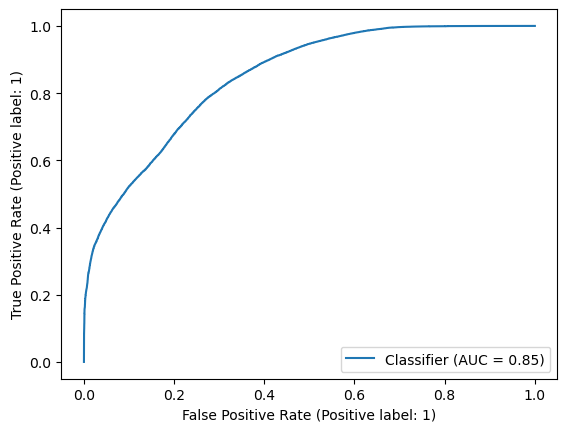

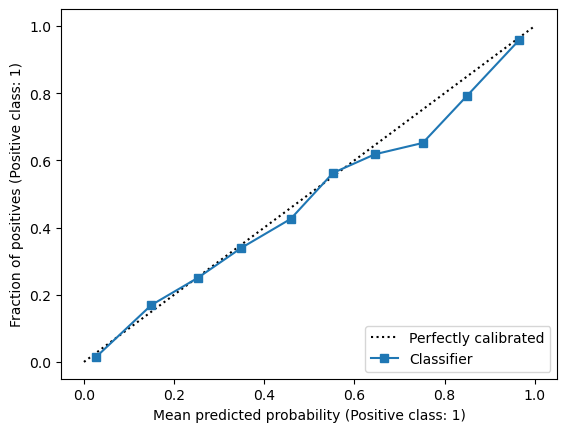

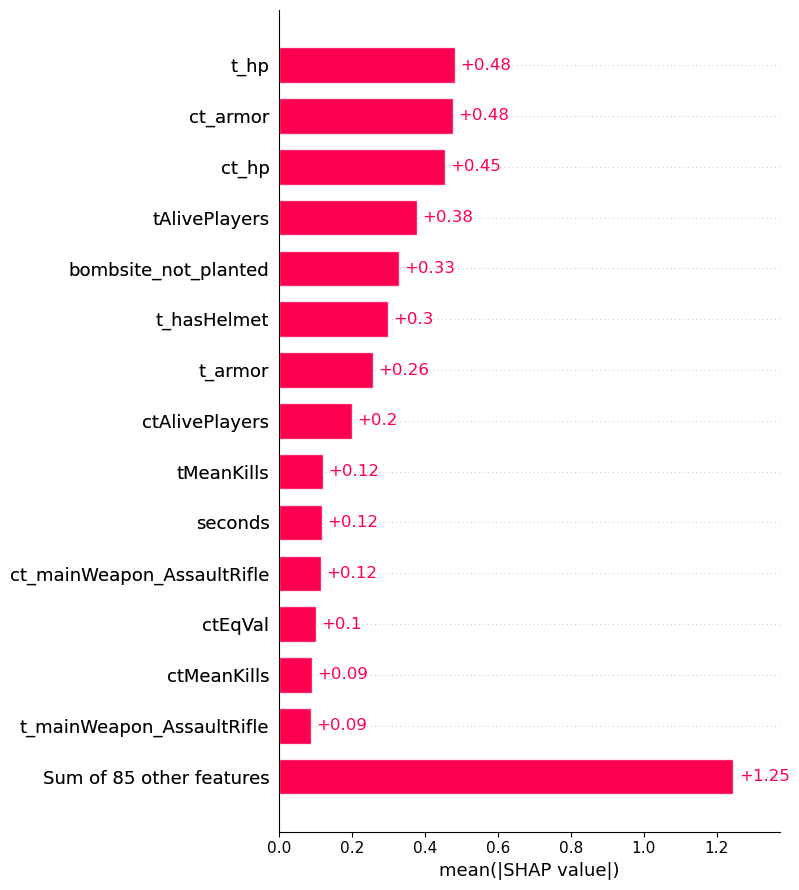

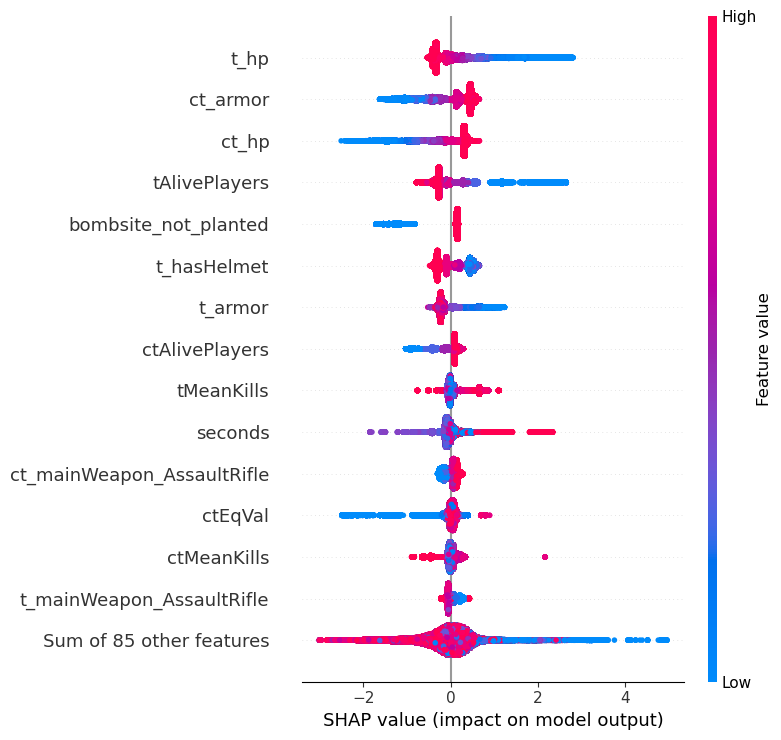

In [18]:
run_name = "XGB - ESTA Test Out Dataset"
additional_description = "XGB ESTA Test Out Dataser"
with mlflow.start_run(run_name=run_name, description=additional_description) as run:
        mlflow.log_params(model_xgb.get_params())
        mlflow.log_param("X_train.shape", X_train.shape)
        mlflow.log_param("X_test.shape", X_test.shape)
        mlflow.log_param("X_test.shape", X_test.shape)
        mlflow.log_params({f"{key}_space": parameters[key] for key in parameters})

        y_proba = model_xgb.predict_proba(X_test)[:, 1]
        y_true = y_test
        features_names = X_train.columns.tolist()
        metrics = {}
        for threshold in np.arange(0.1, 1, 0.05):
            y_pred = (y_proba >= threshold).astype(int)
            metrics[f"accuracy_{threshold:.2f}"] = accuracy_score(y_true=y_true, y_pred=y_pred)
            metrics[f"precision_{threshold:.2f}"] = precision_score(y_true=y_true, y_pred=y_pred)
            metrics[f"recall_{threshold:.2f}"] = recall_score(y_true=y_true, y_pred=y_pred)
            metrics[f"f1_{threshold:.2f}"] = f1_score(y_true=y_true, y_pred=y_pred)
        metrics["roc_auc"] = roc_auc_score(y_true=y_true, y_score=y_proba)
        metrics["log_loss"] = log_loss(y_true=y_true, y_pred=y_proba)
        mlflow.log_metrics(metrics)
        
        
        os.makedirs('artifacts', exist_ok=True)
        with open("artifacts/features.txt", 'w') as f:
            f.write(str(features_names))
            
        os.makedirs('models', exist_ok=True)
        with open("models/model.pkl", "wb") as f:
            pickle.dump(model_xgb, f)

        roc_plot = RocCurveDisplay.from_predictions(y_pred=y_proba, y_true=y_true)
        roc_plot.figure_.savefig('artifacts/roc_auc.jpg')
        plt.show()
        
        calibration_curve = CalibrationDisplay.from_predictions(y_prob=y_proba, y_true=y_true, n_bins=10)
        calibration_curve.figure_.savefig('artifacts/calibration_curve.jpg')
        plt.show()
        
        shap.plots.bar(shap_values, show=False, max_display=15)
        plt.tight_layout()
        plt.savefig('artifacts/shap_importance.jpg')
        plt.show()
        
        shap.plots.beeswarm(shap_values, show=False, max_display=15)
        plt.tight_layout()
        plt.savefig('artifacts/shap_beeplot.jpg')
        plt.show()
        
        mlflow.log_artifacts("artifacts", artifact_path="plots_data")
        mlflow.log_artifacts("models", artifact_path="model")

In [19]:
test_df = pd.read_parquet("data/states_another_mod_test.parquet", columns=select_feat() + ["filename"])
past = test_df['filename'].str.startswith("IEM-Katowice")
future = test_df['filename'].str.startswith("BLAST-Premier-Spring-Final-2022")
test_y = pd.read_parquet("data/states_another_mod_test.parquet", columns=["winningSideCT"])
test_y = test_y.squeeze()
test_df.shape

(620392, 100)

In [20]:
results = []
y_true = test_y
y_pred = model_xgb.predict_proba(test_df.drop("filename", axis="columns"))[:, 1]
results = {
        "LogLoss (all)": log_loss(y_true, y_pred),
        "LogLoss (future)": log_loss(y_true[future], y_pred[future]),
        "LogLoss (past)": log_loss(y_true[past], y_pred[past]),
        "AUC-ROC (all)": roc_auc_score(y_true, y_pred),
        "AUC-ROC (future)": roc_auc_score(y_true[future], y_pred[future]),
        "AUC-ROC (past)": roc_auc_score(y_true[past], y_pred[past])
}
results

{'LogLoss (all)': 0.4669939181061523,
 'LogLoss (future)': 0.4702532265054871,
 'LogLoss (past)': 0.4639548133542689,
 'AUC-ROC (all)': 0.8476278486060692,
 'AUC-ROC (future)': 0.8456008686599088,
 'AUC-ROC (past)': 0.8489496304064905}